# This is the New York City Taxi Fare Prediction Playground Competition 

### To create an appropriate model following steps will be followed:

![](http://storage.googleapis.com/kaggle-media/learn/images/mqTCqBR.png)

Based on this Notebook: https://www.kaggle.com/code/alexisbcook/intro-to-automl

# Step 1: Gathering the Data

In [126]:
# Initial Python environment setup...
import numpy as np # linear algebra
from matplotlib import pyplot as plt # nice& easy plots
import pandas as pd # CSV file I/O (e.g. pd.read_csv)
import os # reading the input files we have access to

train_df =  pd.read_csv("/Users/lucamainitz/Library/Mobile Documents/com~apple~CloudDocs/HAWK/3. Semester/Machine_Learning_WPF/MLA_Kaggle_NY_Taxi_Data/train.csv", nrows = 10_000_000)


# Step 2: Explore & Prepare the Data

Get a general overview of the data we are working with

In [127]:
# check datatypes
print(train_df.dtypes)

# See how data looks in general
print(train_df.head())

# some overview statistics
train_df.describe()

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object
                             key  fare_amount          pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC   
1    2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC   
2   2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC   
3    2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC   
4  2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.000000e+07,1.000000e+07,1.000000e+07,9.999931e+06,9.999931e+06,1.000000e+07
mean,1.133854e+01,-7.250775e+01,3.991934e+01,-7.250897e+01,3.991913e+01,1.684793e+00
std,9.799930e+00,1.299421e+01,9.322539e+00,1.287532e+01,9.237280e+00,1.323423e+00
min,-1.077500e+02,-3.439245e+03,-3.492264e+03,-3.426601e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399139e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396710e+01,4.076712e+01,-7.396367e+01,4.076810e+01,2.000000e+00
max,1.273310e+03,3.457626e+03,3.344459e+03,3.457622e+03,3.351403e+03,2.080000e+02


### Based on the data-exploration - following outliers are unexpected & possibly need to pruned:

* value = null
* fares < 0$, fares > 1000$
* longitude and latitude values < 0 and way outside of NYC
* passenger_count = 0, passenger_count > 9 (max = 208)

## Further follows a thorough examination of the input data

Possible parameters to have a look at and compute min/ max/ mean/ plots/ etc.:
* Fares
* Distances
* Starting an Endpoints
* Number of passengers

In [128]:
# if there are any `NaN`s in the db remove these
train_df = train_df.dropna(how = 'any', axis = 'rows')

### Analysis of the fare amounts including deletion of unrealistic values:

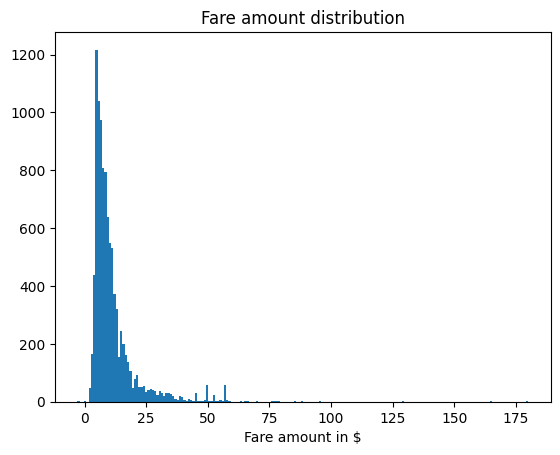

Number of plotted datapoints: 10000
689 unrealistic fare values <= 0 need to be deleted!
Old size: 9999931
New size: 9999123
After dropping off unrealistic values: 
 Mean fare: 11.34 Minimum fare:  0.01 , Maximum fare:  250.0


In [129]:
# Plot fare amount distribution
evalNumber = 10000   # number of datasets evaluated for the plot

fig, ax = plt.subplots()
plt.hist(train_df.fare_amount[:evalNumber], bins=200)
plt.title("Fare amount distribution") 
ax.set_xlabel("Fare amount in $")
plt.show()

print("Number of plotted datapoints:",len(train_df.fare_amount[:evalNumber]))

# count unrealistic fare values <= 0
train_df_negativeFares = train_df[(train_df.fare_amount <= 0)]  
print(len(train_df_negativeFares), "unrealistic fare values <= 0 need to be deleted!")
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.fare_amount > 0)]
train_df = train_df[(train_df.fare_amount <= 250)]
print('New size: %d' % len(train_df))


# check sucess via statistics for fare values
print("After dropping off unrealistic values: \n Mean fare:" , np.round(np.mean(train_df.fare_amount),2),"Minimum fare: ", np.min(train_df.fare_amount), ", Maximum fare: ", np.max(train_df.fare_amount))




We see most of the fares lying between 2$ and 15$ and some peaks between 40$ and 60$. As found out by others, these peaks hint to fixed fares for rides from and to airports and the statue of liberty. Exploring them in a histogram with smaller bin size shows their values at about: 45$, 49.2$, 49.5$, 49.8$, 52$, 56.8$, 57.4$, 57.6$.
Further down we will include this fact to make better predictions. 

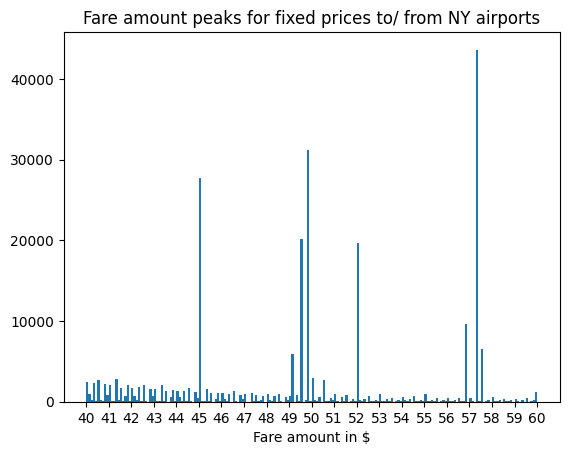

In [130]:
fig, ax = plt.subplots()
plt.hist(train_df.fare_amount, bins=200, range=(40, 60))
plt.title("Fare amount peaks for fixed prices to/ from NY airports") 
ax.set_xlabel("Fare amount in $")
ax.set_xticks(np.arange(40, 61, 1))
plt.show()


### Analysis of the pickup and dropoff coordinates including deletion of unrealistic values :

Min pickup   [long,lat]:  -3439.245062 ,  -3492.263768
Min dropoff  [long,lat]:  -3426.600617 ,  -3488.079513
Mean pickup  [long,lat]:  -72.508148 ,  39.919555
Mean dropoff [long,lat]:  -72.509597 ,  39.919473
Max pickup   [long,lat]:  3457.625683 ,  3344.459268
Max dropoff  [long,lat]:  3457.62235 ,  3351.403027
Old size: 9999123
New size: 9790895
208228  data points were deleted due to unrealistic coordinates, that are not in the vincinity of NYC!

Evaluation after deletion of unrealistic values:
Min pickup   [long,lat]:  -75.946482 ,  38.299658
Min dropoff  [long,lat]:  -75.960413 ,  38.311708
Mean pickup  [long,lat]:  -73.975272 ,  40.750924
Mean dropoff [long,lat]:  -73.974391 ,  40.751275
Max pickup   [long,lat]:  -72.060575 ,  41.983852
Max dropoff  [long,lat]:  -72.066997 ,  41.998107

Check via histograms that we didn't cut relevant data:


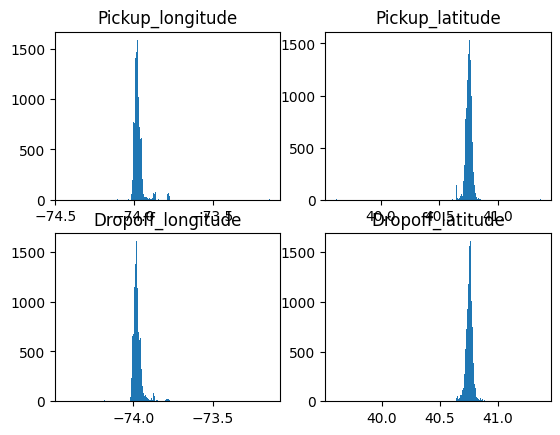

In [131]:
# some stats about our coordinates
# Expectations based on the coordinates of NYC and its surrounding: 
longMin = -76
longMax = -72
latMin = 38
latMax = 42

# # NYC-Map to see coordinates frame
# plt.imshow(plt.imread("../input/images/mapNYC_area.jpg"))
# plt.axis('off')
# plt.show()

print("Min pickup   [long,lat]: ", np.min(train_df.pickup_longitude),", ",np.min(train_df.pickup_latitude))
print("Min dropoff  [long,lat]: ", np.min(train_df.dropoff_longitude),", ",np.min(train_df.dropoff_latitude))
print("Mean pickup  [long,lat]: ", np.round(np.mean(train_df.pickup_longitude),6),", ",np.round(np.mean(train_df.pickup_latitude),6))
print("Mean dropoff [long,lat]: ", np.round(np.mean(train_df.dropoff_longitude),6),", ",np.round(np.mean(train_df.dropoff_latitude),6))
print("Max pickup   [long,lat]: ", np.max(train_df.pickup_longitude),", ",np.max(train_df.pickup_latitude))
print("Max dropoff  [long,lat]: ", np.max(train_df.dropoff_longitude),", ",np.max(train_df.dropoff_latitude))

# find unrealistic coordinates & remove datapoints
oldLen = len(train_df)
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.pickup_longitude >= longMin) & (train_df.pickup_longitude <= longMax)
                   & (train_df.dropoff_longitude >= longMin) & (train_df.dropoff_longitude <= longMax) 
                   & (train_df.pickup_latitude >= latMin) & (train_df.pickup_latitude <= latMax) 
                   & (train_df.dropoff_latitude >= latMin) & (train_df.dropoff_latitude <= latMax)]
print('New size: %d' % len(train_df))
print(oldLen -len(train_df)," data points were deleted due to unrealistic coordinates, that are not in the vincinity of NYC!")

print("\nEvaluation after deletion of unrealistic values:" )
print("Min pickup   [long,lat]: ", np.min(train_df.pickup_longitude),", ",np.min(train_df.pickup_latitude))
print("Min dropoff  [long,lat]: ", np.min(train_df.dropoff_longitude),", ",np.min(train_df.dropoff_latitude))
print("Mean pickup  [long,lat]: ", np.round(np.mean(train_df.pickup_longitude),6),", ",np.round(np.mean(train_df.pickup_latitude),6))
print("Mean dropoff [long,lat]: ", np.round(np.mean(train_df.dropoff_longitude),6),", ",np.round(np.mean(train_df.dropoff_latitude),6))
print("Max pickup   [long,lat]: ", np.max(train_df.pickup_longitude),", ",np.max(train_df.pickup_latitude))
print("Max dropoff  [long,lat]: ", np.max(train_df.dropoff_longitude),", ",np.max(train_df.dropoff_latitude))

#plot coordinates
print("\nCheck via histograms that we didn't cut relevant data:")
fig1 = plt.figure()

plt.subplot(2, 2, 1)
plt.hist(train_df.pickup_longitude[:evalNumber], bins=200)
plt.title("Pickup_longitude") 

plt.subplot(2, 2, 2)
plt.hist(train_df.pickup_latitude[:evalNumber], bins=200)
plt.title("Pickup_latitude") 

plt.subplot(2, 2, 3)
plt.hist(train_df.dropoff_longitude[:evalNumber], bins=200)
plt.title("Dropoff_longitude") 

plt.subplot(2, 2, 4)
plt.hist(train_df.dropoff_latitude[:evalNumber], bins=200)
plt.title("Dropoff_latitude") 
plt.show()

### Analysis of passenger number:

Mean passenger number:  1.7 Minimum passenger number:  0 , Maximum passenger number:  208


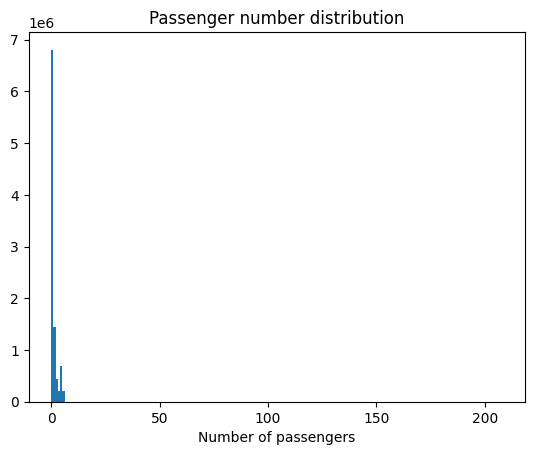

Number of plotted datapoints: 9790895
34518 data points with zero passengers need to be deleted!
4 data points with more than 9 passengers found: 
208
129
208
208
How big are our taxis? ;)
Old size: 9790895
New size: 9756373


In [132]:
# output some statistics for the number of passengers
print("Mean passenger number: ", np.round(np.mean(train_df.passenger_count),1),"Minimum passenger number: ", np.min(train_df.passenger_count), ", Maximum passenger number: ", np.max(train_df.passenger_count))

# Plot passenger distribution
evalNumber = len(train_df.passenger_count)   # number of datasets evaluated for the plot

fig, ax = plt.subplots()
plt.hist(train_df.passenger_count[:evalNumber], bins=200)
plt.title("Passenger number distribution") 
ax.set_xlabel("Number of passengers")
plt.show()
print("Number of plotted datapoints:",len(train_df.passenger_count[:evalNumber]))


# count unrealistic passenger values = 0
train_df_Zero_Passengers = train_df[(train_df.passenger_count == 0)]
print(len(train_df_Zero_Passengers), "data points with zero passengers need to be deleted!")

train_df_many_Passengers = train_df[(train_df.passenger_count > 10)]
print(len(train_df_many_Passengers), "data points with more than 9 passengers found: ")
for num in train_df_many_Passengers.passenger_count:
    print(num)
print("How big are our taxis? ;)") 

# delete data points with 0 passengers and more than 10 passengers
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.passenger_count != 0) & (train_df.passenger_count < 10)]
print('New size: %d' % len(train_df))

## Based on the existing data new features are created & explored

### Creation of the absolute difference in longitude & latitude

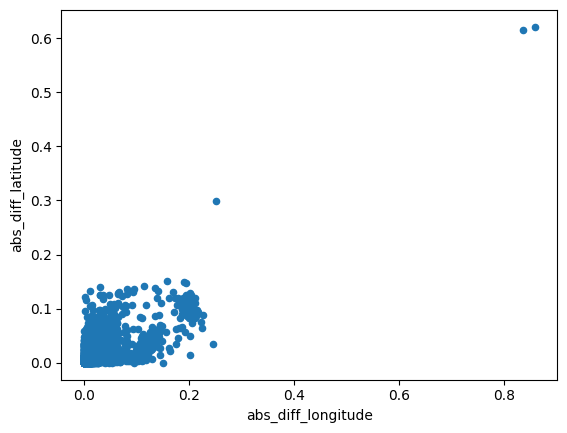

In [133]:
# add two new features 'abs_diff_longitude' and
# 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)

# Now let's quickly plot a subset of our travel vector features to see its distribution.
plot = train_df.iloc[:4000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

### Analysis of travel distances:

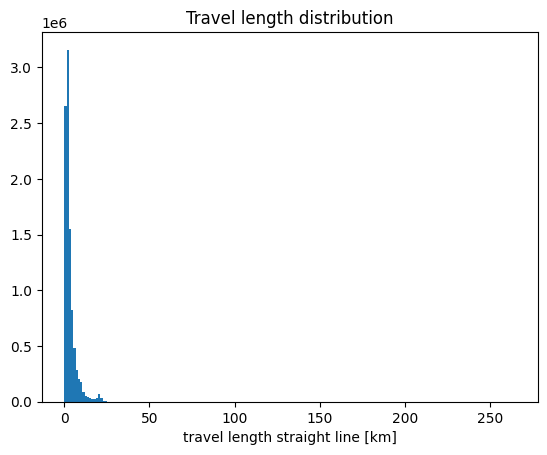

Number of plotted datapoints: 9756373
Mean straight line distance:  3.35 km, Minimum distance:  0.0 km, Maximum distance:  264.7128832066417 km
Old size: 9756373
New size: 9652416
Number of rides wtih travel distance <50m:  42029


In [134]:
import math

#straight line distances:

# approximation:
    # 1degree latitude = 111.5km 
    # 1degree longitude = 84km
lat2km = 111.5
long2km = 84

# add travel length feature:
def add_straight_distance_feature(df):
    df['straight_distance'] = (((train_df.abs_diff_longitude * long2km)**2+(train_df.abs_diff_latitude * lat2km)**2)**0.5)
    df['straight_distance'] = df['straight_distance'].fillna(0)
    
add_straight_distance_feature(train_df)

# plot travel distances as histogram
evalNumber = len(train_df.straight_distance)   # number of datasets evaluated for the plot

fig, ax = plt.subplots()
plt.hist(train_df.straight_distance[:evalNumber], bins=200)
plt.title("Travel length distribution") 
ax.set_xlabel("travel length straight line [km]")
plt.show()

# output some statistics for fare values
print("Number of plotted datapoints:",len(train_df.straight_distance[:evalNumber]))
print("Mean straight line distance: ", np.round(np.mean(train_df.straight_distance),2),"km, Minimum distance: ", np.min(train_df.straight_distance), "km, Maximum distance: ", np.max(train_df.straight_distance),"km")

# remove travel distances = 0
oldLen = len(train_df)
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.straight_distance != 0)]
print('New size: %d' % len(train_df))

train_df.straight_distance.describe()
# still very short travel distances included, so check if their number might be relevant:
train_df_shortest = train_df[(train_df.straight_distance < 0.05)]
print('Number of rides wtih travel distance <50m: ', len(train_df_shortest))
#train_df_shortest.fare_amount.describe()


### Adding Manhatten Distance

In [135]:

# add manhatten distance feature:

def add_manhattan_distance(df):
    df['manhattan_distance'] = df.abs_diff_longitude + df.abs_diff_latitude
    df['manhattan_distance'] = df['manhattan_distance'].fillna(0)

add_manhattan_distance(train_df)


### Adding Airport distances 

In [136]:
# To Compute Haversine distance
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    return 2 * R_earth * np.arcsin(np.sqrt(a))

def add_airport_dist(dataset):
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    SOL: Statue of Liberty 
    NYC: Newyork Central
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    sol_coord = (40.6892,-74.0445) # Statue of Liberty
    nyc_coord = (40.7141667,-74.0063889) 
    
    
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    
    pickup_jfk = sphere_dist(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = sphere_dist(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = sphere_dist(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = sphere_dist(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = sphere_dist(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = sphere_dist(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon)
    pickup_sol = sphere_dist(pickup_lat, pickup_lon, sol_coord[0], sol_coord[1]) 
    dropoff_sol = sphere_dist(sol_coord[0], sol_coord[1], dropoff_lat, dropoff_lon)
    pickup_nyc = sphere_dist(pickup_lat, pickup_lon, nyc_coord[0], nyc_coord[1]) 
    dropoff_nyc = sphere_dist(nyc_coord[0], nyc_coord[1], dropoff_lat, dropoff_lon)
    
    
    
    dataset['jfk_dist'] = pickup_jfk + dropoff_jfk
    dataset['ewr_dist'] = pickup_ewr + dropoff_ewr
    dataset['lga_dist'] = pickup_lga + dropoff_lga
    dataset['sol_dist'] = pickup_sol + dropoff_sol
    dataset['nyc_dist'] = pickup_nyc + dropoff_nyc
    
    return dataset

add_airport_dist(train_df)
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,straight_distance,manhattan_distance,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist
count,9.652416e+06,9.652416e+06,9.652416e+06,9.652416e+06,9.652416e+06,9.652416e+06,9.652416e+06,9.652416e+06,9.652416e+06,9.652416e+06,9.652416e+06,9.652416e+06,9.652416e+06,9.652416e+06,9.652416e+06
mean,1.133105e+01,-7.397558e+01,4.075083e+01,-7.397469e+01,4.075119e+01,1.690723e+00,2.313923e-02,2.170401e-02,3.389762e+00,4.484325e-02,4.191022e+01,3.565047e+01,1.959074e+01,1.888916e+01,1.114898e+01
std,9.591090e+00,3.812050e-02,3.046691e-02,3.666623e-02,3.387326e-02,1.306238e+00,3.723173e-02,2.739334e-02,4.153792e+00,5.620210e-02,5.251623e+00,5.973539e+00,5.183632e+00,6.445679e+00,6.535190e+00
min,1.000000e-02,-7.594648e+01,3.829966e+01,-7.596041e+01,3.831171e+01,1.000000e+00,0.000000e+00,0.000000e+00,8.400000e-05,1.000000e-06,4.914537e-01,8.571477e-01,2.145543e-01,5.325453e-01,5.488324e-02
25%,6.000000e+00,-7.399230e+01,4.073656e+01,-7.399159e+01,4.073559e+01,1.000000e+00,6.317139e-03,7.131000e-03,1.278780e+00,1.668400e-02,4.132021e+01,3.211481e+01,1.705621e+01,1.480397e+01,7.058247e+00
50%,8.500000e+00,-7.398213e+01,4.075336e+01,-7.398064e+01,4.075388e+01,1.000000e+00,1.285000e-02,1.435000e-02,2.178309e+00,2.840805e-02,4.248474e+01,3.465226e+01,1.951048e+01,1.818911e+01,1.030406e+01
75%,1.250000e+01,-7.396846e+01,4.076754e+01,-7.396553e+01,4.076840e+01,2.000000e+00,2.410200e-02,2.741600e-02,3.947312e+00,5.123400e-02,4.368140e+01,3.801697e+01,2.202289e+01,2.210143e+01,1.413490e+01
max,2.500000e+02,-7.206058e+01,4.198385e+01,-7.206700e+01,4.199811e+01,9.000000e+00,1.957202e+00,2.368970e+00,2.647129e+02,3.639052e+00,5.833551e+02,5.565682e+02,5.991255e+02,5.668794e+02,5.750191e+02


### Correlation of travel distance and travel fare:

Number of evaluted data sets:  1000000


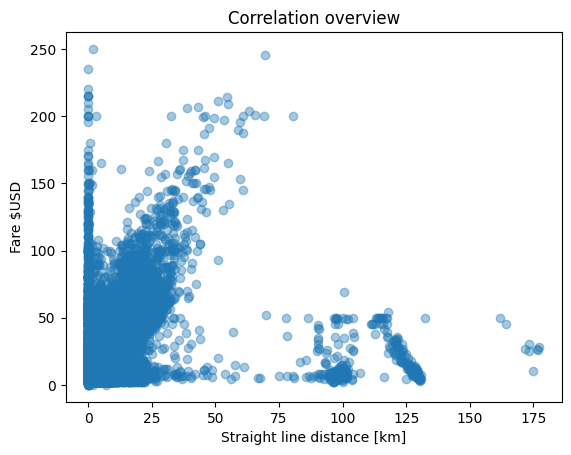

In [137]:
# scatter plot distance - fare

# Plot passenger distribution
evalNumber = 1000000   # number of datasets evaluated for the plot

fig, axs = plt.subplots()
axs.scatter(train_df.straight_distance[:evalNumber], train_df.fare_amount[:evalNumber], alpha=0.4)
axs.set_xlabel('Straight line distance [km]')
axs.set_ylabel('Fare $USD')
axs.set_title('Correlation overview')
print('Number of evaluted data sets: ', len(train_df.straight_distance[:evalNumber]))

### Add day time of travel as further input:

based on: https://www.kaggle.com/code/jsylas/python-version-of-top-ten-rank-r-22-m-2-88/script

In [138]:
def add_datetime_info(dataset):
    #Convert to datetime format
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")
    
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['weekday'] = dataset.pickup_datetime.dt.weekday
    dataset['year'] = dataset.pickup_datetime.dt.year
    
    return dataset

train_df = add_datetime_info(train_df)
# output stats for hour/ day time
train_df.hour.describe()



count    9.652416e+06
mean     1.351330e+01
std      6.516090e+00
min      0.000000e+00
25%      9.000000e+00
50%      1.400000e+01
75%      1.900000e+01
max      2.300000e+01
Name: hour, dtype: float64

### Add Late night surcharge

In [139]:

def add_rush_hour (df):
    if ((df['hour'] >= 7) & (df['hour'] <= 9)) | ((df['hour'] >= 16) & (df['hour'] <= 18)):
        val = 1
    else:
        val = 0
    return val

def add_late_night (df):
    if (df['hour'] <= 6) | (df['hour'] >= 20):
        val = 1
    else:
        val = 0
    return val


def add_night (df):
    if ((df['hour'] <= 20) & (df['hour'] >= 16)) & (df['weekday'] < 5):
        val = 1
    else:
        val = 0
    return val

In [140]:
# train_df['rush_hour'] = train_df.apply(add_rush_hour, axis=1)
# train_df['late_night'] = train_df.apply(add_late_night, axis=1)
# train_df['night'] = train_df.apply(add_night, axis=1)

print(train_df.describe())

        fare_amount                pickup_datetime  pickup_longitude  \
count  9.652416e+06                        9652416      9.652416e+06   
mean   1.133105e+01  2012-03-22 10:11:43.245733120     -7.397558e+01   
min    1.000000e-02            2009-01-01 00:00:46     -7.594648e+01   
25%    6.000000e+00  2010-08-16 08:07:00.750000128     -7.399230e+01   
50%    8.500000e+00            2012-03-23 18:26:23     -7.398213e+01   
75%    1.250000e+01            2013-10-23 10:52:00     -7.396846e+01   
max    2.500000e+02            2015-06-30 23:59:54     -7.206058e+01   
std    9.591090e+00                            NaN      3.812050e-02   

       pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
count     9.652416e+06       9.652416e+06      9.652416e+06     9.652416e+06   
mean      4.075083e+01      -7.397469e+01      4.075119e+01     1.690723e+00   
min       3.829966e+01      -7.596041e+01      3.831171e+01     1.000000e+00   
25%       4.073656e+01      -7.

### Feature selection & Scaling

In [141]:
# adapt size for faster test runs
# train_df = train_df.iloc[:100000]   # Observation 05.01. : Training with 1.000.000 or 100.000 doesn't show any difference is resulting score
train_df.tail()


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,...,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,hour,day,month,weekday,year
9999995,2012-08-12 01:18:00.000000208,5.7,2012-08-12 01:18:00,-73.999464,40.728452,-73.993299,40.742100,2,0.006165,0.013648,...,42.417121,30.577734,22.874572,13.079800,4.988344,1,12,8,6,2012
9999996,2013-08-07 10:28:00.000000147,5.5,2013-08-07 10:28:00,-73.968467,40.759367,-73.964967,40.769027,1,0.003500,0.009660,...,42.072620,37.585360,16.144429,21.218134,12.983468,10,7,8,2,2013
9999997,2013-10-29 08:29:00.00000082,14.0,2013-10-29 08:29:00,-73.997952,40.733717,-73.973448,40.759122,5,0.024504,0.025405,...,42.324600,33.133799,20.342237,16.129625,8.004804,8,29,10,1,2013
9999998,2012-04-07 16:41:33.0000004,10.5,2012-04-07 16:41:33,-73.992700,40.752021,-73.964705,40.772849,1,0.027995,0.020828,...,43.479486,35.599943,18.265876,19.714291,11.774492,16,7,4,5,2012
9999999,2010-03-30 19:27:00.00000066,8.5,2010-03-30 19:27:00,-73.965390,40.768572,-73.998188,40.761073,1,0.032798,0.007499,...,44.158082,35.358834,18.599252,19.954252,12.227536,19,30,3,1,2010


In [142]:
from sklearn import model_selection, preprocessing

# splitte die labels von den features
def defineLabels(df):
    scaler = preprocessing.MinMaxScaler()
    labels_df = df[['fare_amount']].copy()
    labels_scaled = scaler.fit_transform(labels_df)
    return labels_scaled

train_labels_scaled = defineLabels(train_df)

# Url vom Beispiel - https://www.tensorflow.org/tutorials/keras/regression
# selektiere die features
def defineFeatures(df):  
    scaler = preprocessing.MinMaxScaler()
    # features_df = df[['straight_distance', 'manhattan_distance', 'hour', 'day', 'month', 'weekday', 'year', 'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist', 'night', 'late_night', 'rush_hour']].copy()
    features_df = df[['straight_distance']].copy()
    features_scaled = scaler.fit_transform(features_df)
    return features_scaled

train_features_scaled = defineFeatures(train_df)

# Split the data into training and testing sets
# x = features, y = labels
train_x, val_x, train_y, val_y = model_selection.train_test_split(train_features_scaled, train_labels_scaled, test_size=0.2, random_state=42)

train_x = train_x[:80000]
train_y = train_y[:80000]
val_x = val_x[:20000]
val_y = val_y[:20000]

print(train_x, train_y)


[[0.03091844]
 [0.00513601]
 [0.01031539]
 ...
 [0.00401579]
 [0.01467628]
 [0.0057859 ]] [[0.15528621]
 [0.0275611 ]
 [0.04356174]
 ...
 [0.01956078]
 [0.06596264]
 [0.02396096]]


# Step 3: Select a Model

In [143]:
import tensorflow as tf
print(tf.__version__)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import regularizers
import keras

# normalisierungslayer --> will irgendwie gerade nicht 
# normalizer = tf.keras.layers.Normalization(axis=None)

# model = keras.Sequential()
# model.add(keras.layers.Dense(256, activation='relu', input_dim=train_x.shape[1], activity_regularizer=regularizers.l1(0.01)))
# model.add(BatchNormalization())
# model.add(keras.layers.Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(keras.layers.Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(keras.layers.Dense(32, activation='relu'))
# model.add(BatchNormalization())
# model.add(keras.layers.Dense(8, activation='relu'))
# model.add(BatchNormalization())
# model.add(keras.layers.Dense(1))

model = keras.Sequential()
model.add(keras.layers.Dense(16, activation='relu', input_dim=train_x.shape[1], activity_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(keras.layers.Dense(1))

model.compile(
    loss='mean_squared_error', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[keras.metrics.RootMeanSquaredError()])

model.summary()

2.15.0
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                32        
                                                                 
 batch_normalization_5 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 batch_normalization_6 (Bat  (None, 8)                 32        
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 273 (1.07 KB)
Trainable params: 2

In [144]:
from keras.callbacks import EarlyStopping
# train the model
epochs = 200
batch_size = 512

# define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30)

# train the model with early stopping
history = model.fit(
    train_x,
    train_y,
    verbose=1,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(val_x, val_y),
    callbacks=[early_stopping])



Epoch 1/200
157/157 [==============================] - 0s 985us/step - loss: 0.0216 - root_mean_squared_error: 0.1465 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0583
Epoch 2/200
157/157 [==============================] - 0s 582us/step - loss: 0.0028 - root_mean_squared_error: 0.0518 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0804
Epoch 3/200
157/157 [==============================] - 0s 571us/step - loss: 0.0015 - root_mean_squared_error: 0.0370 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0972
Epoch 4/200
157/157 [==============================] - 0s 561us/step - loss: 9.3996e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0654
Epoch 5/200
157/157 [==============================] - 0s 561us/step - loss: 7.0640e-04 - root_mean_squared_error: 0.0247 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0847
Epoch 6/200
157/157 [==============================] - 0s 546us/step - loss: 6.0332e-04 - root_mean_squared_error: 0.

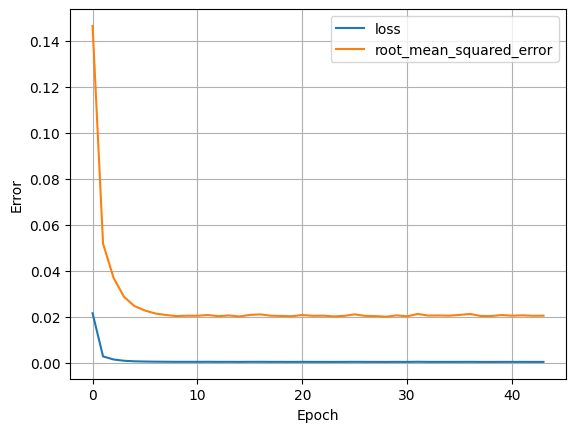

In [145]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

# Save the entire model as a `.keras` zip archive.
model.save('my_model.keras')

# load keras model
model = keras.models.load_model('my_model.keras')

In [146]:
# evaluate model performance
score = model.evaluate(val_x, val_y, verbose=0)
print("Test loss: {:.4f}".format(score[0]))
print("Test accuracy: {:.4f}".format(score[1]))


Test loss: 0.0013
Test accuracy: 0.0358


In [147]:
# test data alsready loaded as test_df
test_df = pd.read_csv("/Users/lucamainitz/Library/Mobile Documents/com~apple~CloudDocs/HAWK/3. Semester/Machine_Learning_WPF/MLA_Kaggle_NY_Taxi_Data/test.csv")

# create used features
add_travel_vector_features(test_df)
add_straight_distance_feature(test_df)
add_manhattan_distance(test_df)
add_datetime_info(test_df)
add_airport_dist(test_df)
test_df['rush_hour'] = test_df.apply(add_rush_hour, axis=1)
test_df['late_night'] = test_df.apply(add_late_night, axis=1)
test_df['night'] = test_df.apply(add_night, axis=1)

# check for null values in extented test data to avoid wrong predictions
print(test_df.isnull().sum())

# print(test_df.head())
# print(test_df.describe())

# select columns for prediction
test_features_scaled = defineFeatures(test_df)

# predict on data
prediction = model.predict(test_features_scaled, verbose=1)

# print(len(prediction))

key                   0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count       0
abs_diff_longitude    0
abs_diff_latitude     0
straight_distance     0
manhattan_distance    0
hour                  0
day                   0
month                 0
weekday               0
year                  0
jfk_dist              0
ewr_dist              0
lga_dist              0
sol_dist              0
nyc_dist              0
rush_hour             0
late_night            0
night                 0
dtype: int64
310/310 [==============================] - 0s 256us/step


### Make Kaggle Submission

In [151]:
submission = pd.DataFrame(prediction, columns=['fare_amount'])
submission.insert(0, "key", test_df.key, True)

print(submission.head())

# submission_null = submission[submission['fare_amount'].isnull()]

# # Add values from test_df with matching key column to submission_null
# submission_null = submission_null.merge(test_df, on='key', how='left')
# submission_null.to_csv('submission_null.csv', index = False)
# print(submission_null.head())

submission.to_csv('submission.csv', index = False)

# pd.DataFrame(data=data[1:,1:],    # values
#              index=test_df[1:,0],    # 1st column as index
#              columns=data[0,1:])  # 1st row as the column names


                           key  fare_amount
0  2015-01-27 13:08:24.0000002     0.009199
1  2015-01-27 13:08:24.0000003     0.268735
2  2011-10-08 11:53:44.0000002     0.017650
3  2012-12-01 21:12:12.0000002     0.051056
4  2012-12-01 21:12:12.0000003     0.032069


In [149]:
submission.to_csv();